In [51]:
# Importing libraries
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geoplot as gplt 
import geopandas as gpd
import geoplot.crs as gcrs
from shapely.geometry import Point
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

In [52]:
# Data cleaning

#importing datasets needed
df = pd.read_csv("../FinalDataStory/datasets/NTAD_National_Bridge_Inventory_2178055625219331056.csv")
districts_df = gpd.read_file("../FinalDataStory/datasets/MO_MoDOT_Districts-20250502T153848Z-1-001/MO_MoDOT_Districts/MO_MoDOT_Districts.shp")

districts_df.head()
df.head()

#get list of columns to pick which ones i will need
col_names = df.columns.to_list()
#print(col_names)

#picking columns that i want
filtered_df = df[["OBJECTID", "STATE_CODE_001", "STRUCTURE_NUMBER_008", "COUNTY_CODE_003", "FACILITY_CARRIED_007"
                 , "LAT_016", "LONG_017", "YEAR_BUILT_027", "TRAFFIC_LANES_ON_028A", "ADT_029", "YEAR_ADT_030", 
                 "BRIDGE_IMP_COST_094", "YEAR_RECONSTRUCTED_106", "FUTURE_ADT_114", "YEAR_OF_FUTURE_ADT_115", 
                 "BRIDGE_CONDITION", "STRUCTURE_LEN_MT_049"]]

filtered_df.head()


,OBJECTID,STATE_CODE_001,STRUCTURE_NUMBER_008,COUNTY_CODE_003,FACILITY_CARRIED_007,LAT_016,LONG_017,YEAR_BUILT_027,TRAFFIC_LANES_ON_028A,ADT_029,YEAR_ADT_030,BRIDGE_IMP_COST_094,YEAR_RECONSTRUCTED_106,FUTURE_ADT_114,YEAR_OF_FUTURE_ADT_115,BRIDGE_CONDITION,STRUCTURE_LEN_MT_049
0,290899,29,1,21,MO 6 E,39463723,94473709,1958,6,15423,2023,NaN,1992,20821,2043,F,61.6
1,290900,29,10,25,US 36 E,39440616,93562572,1958,4,8566,2023,NaN,2000,17989,2043,F,6.4
2,290901,29,100,165,IS 29 S,39273317,94471789,1958,4,36821,2023,204.0,0,75483,2043,P,6.6
3,290902,29,1000,77,US 60 E,37072768,93133368,1965,2,15996,2023,NaN,2009,24794,2043,F,120.4
4,290903,29,10000,67,MO 76 E,36581862,92254722,1940,2,419,2023,NaN,0,649,2043,F,15.5


Text(0, 0.5, '# of bridges')

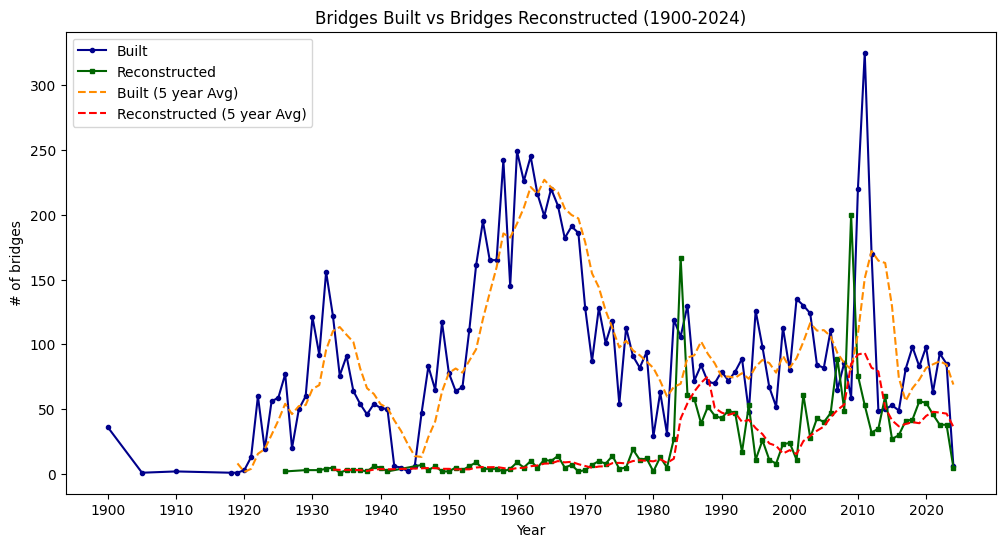

In [53]:
# Time series: Bridges built per year with bridges reconstructed per year

fig, ax = plt.subplots(figsize=(12,6))

#getting bridges and bridges reconstructed per year
bridges_per_year = filtered_df.groupby("YEAR_BUILT_027")["OBJECTID"].count()
reconst_per_year = filtered_df.groupby("YEAR_RECONSTRUCTED_106")["OBJECTID"].count()

#filtering out the first row (there are alot that have zeros = not reconstructed)
reconst_per_year = reconst_per_year.iloc[1:]
#print(reconst_per_year)

#plotting
ax.plot(bridges_per_year.index, bridges_per_year.values, marker="o", ms=3, label="Built", color="darkblue")
ax.plot(reconst_per_year.index, reconst_per_year.values, marker="s", ms=3, label="Reconstructed", color="darkgreen")

#plotting rolling avgs for each dataset to be more descriptive
bridges_built_rolling = bridges_per_year.rolling(window=5).mean()
reconst_rolling = reconst_per_year.rolling(window=5).mean()
ax.plot(bridges_built_rolling.index, bridges_built_rolling.values, label="Built (5 year Avg)", linestyle="--", color="darkorange")
ax.plot(reconst_rolling.index, reconst_rolling.values, label="Reconstructed (5 year Avg)", linestyle="--", color="red")

#final touches
ax.set_xticks(np.arange(1900, 2025, 10)) #doing every 10 years instead of every 20
ax.set_title("Bridges Built vs Bridges Reconstructed (1900-2024)")
ax.legend()
ax.set_xlabel("Year")
ax.set_ylabel("# of bridges")

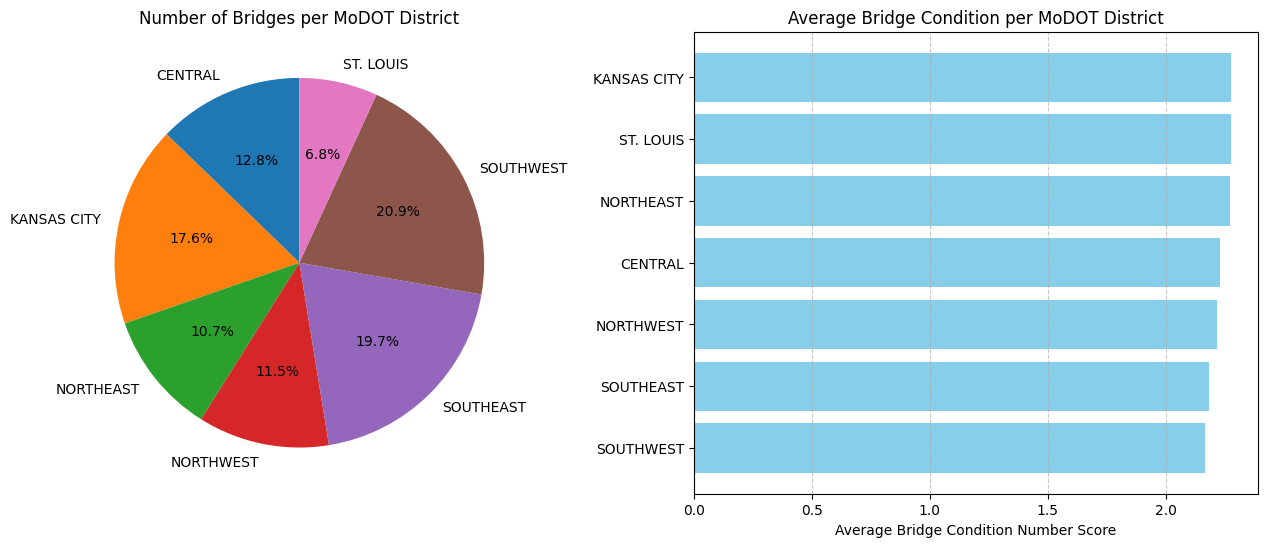

In [54]:
# Pie chart: Number of bridges per district, Condition by district

#need to convert lat and longitude to decimal format so we can join with districts df
geometry_dfs = filtered_df.copy()
geometry_dfs['lat'] = geometry_dfs['LAT_016'] / 1e6
geometry_dfs['lon'] = -geometry_dfs['LONG_017'] / 1e6

#turning it into a geometry df
bridges_gdf = gpd.GeoDataFrame(geometry_dfs, geometry=gpd.points_from_xy(geometry_dfs['lon'], geometry_dfs['lat']), crs="EPSG:4326")
bridges_gdf = bridges_gdf.to_crs(districts_df.crs)

bridges_gdf.head()

#joining the added geometry items of og df with the districts df, and get the counts of each
joined = gpd.sjoin(bridges_gdf, districts_df, how='inner', predicate='within')

bridge_counts = ( #getting counts of bridges by district
    joined.groupby(['DISTRICT_1', 'DISTRICT_N'])
    .size()
    .reset_index(name='bridge_count')
)
bridge_counts.head()
joined.head()

#now plotting both the number of bridges and condition side by side
condition_map = {
    "P" : 1, #poor
    "F" : 2, #fair
    "G" : 3, #good
    "E" : 4  #excellent?
}

joined['condition_number'] = joined['BRIDGE_CONDITION'].map(condition_map)
joined.head()

avg_condition = (
    joined.groupby(["DISTRICT_1", "DISTRICT_N"])["condition_number"]
    .mean()
    .reset_index(name="avg_condition")
)
avg_condition = avg_condition.sort_values('avg_condition')

# --- subplots ---
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#pie chart for number of bridges per missouri district
axes[0].pie(
    bridge_counts["bridge_count"],
    labels=bridge_counts["DISTRICT_1"],
    autopct="%1.1f%%",
    startangle=90
)
axes[0].set_title("Number of Bridges per MoDOT District")

#bar chart for average condition per missouri district
axes[1].barh(
    avg_condition["DISTRICT_1"],
    avg_condition['avg_condition'],
    color='skyblue'
)
axes[1].set_xlabel("Average Bridge Condition Number Score")
axes[1].set_title("Average Bridge Condition per MoDOT District")
axes[1].grid(axis='x', linestyle='--', alpha=0.7)

plt.show()


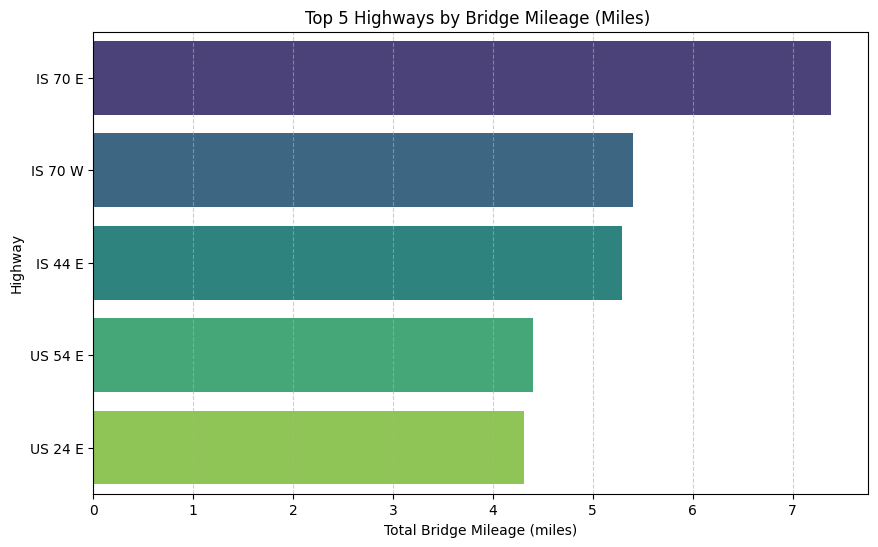

In [56]:
# Bar Chart: Top 5 highways with number of bridge mileage

filtered_for_miles = filtered_df.copy()
filtered_for_miles['bridge_miles'] = filtered_for_miles['STRUCTURE_LEN_MT_049'] / 1609.34 #getting brdige mileage from the col that has bridge mileage in meters

#get top 5 highways based on bridge mileage
top_highways = (
    filtered_for_miles.groupby('FACILITY_CARRIED_007')['bridge_miles']
    .sum()
    .reset_index(name='total_mileage')
    .sort_values('total_mileage', ascending=False)
    .head(5)
)

plt.figure(figsize=(10, 6))
sns.barplot( #plotting with seaborn
    data=top_highways,
    x='total_mileage',
    y='FACILITY_CARRIED_007',
    palette='viridis'
)
plt.xlabel("Total Bridge Mileage (miles)")
plt.ylabel("Highway")
plt.title("Top 5 Highways by Bridge Mileage (Miles) ")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()
